# San Francisco Crime prediction 
# Based on 2 layer neural net and count featurizer

In [339]:
import os
import pandas as pd
import re
import time

import numpy as np
from datetime import datetime
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm
from sklearn.decomposition import PCA
from keras.layers.advanced_activations import PReLU
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils
from copy import deepcopy

import accelerate
import mkl

%matplotlib inline  

Import data

In [2]:
data_path = "data"
submissions_path = "submissions"

In [41]:
trainDF=pd.read_csv(os.path.join(data_path, "train.csv"))


Clean up wrong X and Y values (very few of them)

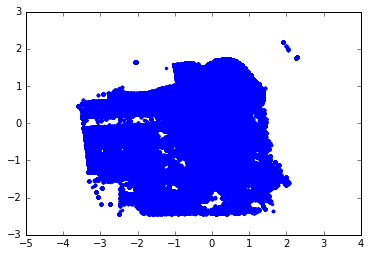

In [168]:
xy_scaler=preprocessing.StandardScaler()
xy_scaler.fit(trainDF[["X","Y"]])
trainDF[["X","Y"]]=xy_scaler.transform(trainDF[["X","Y"]])
trainDF=trainDF[abs(trainDF["Y"])<100]
trainDF.index=range(len(trainDF))
plt.plot(trainDF["X"],trainDF["Y"],'.')
plt.axis('equal')
plt.show()

In [43]:
trainDF.shape


(877982, 9)

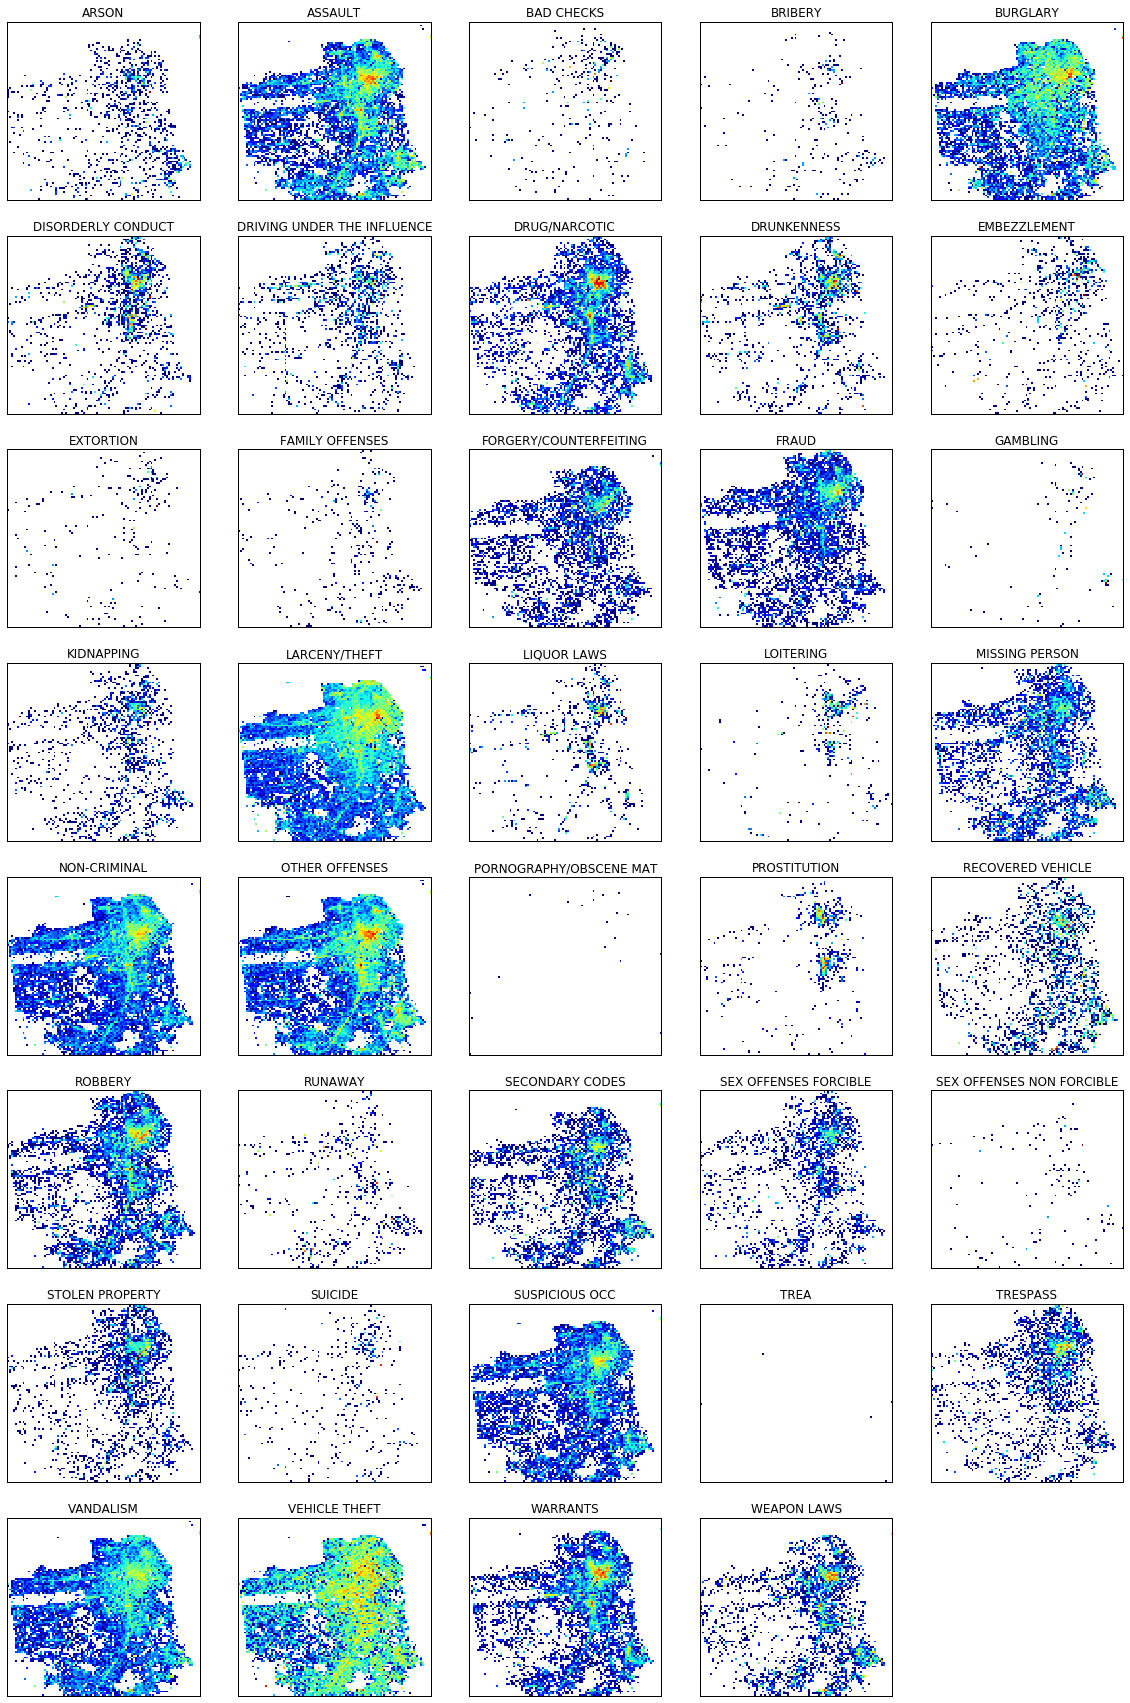

In [153]:
# Make plots for each crime label

NX=100
NY=100
groups = trainDF.groupby('Category')
ii=1
plt.figure(figsize=(20, 30))
for name, group in groups:
    plt.subplot(8,5,ii)
    histo, xedges, yedges = np.histogram2d(np.array(group.X),np.array(group.Y), bins=(NX,NY))
    myextent  =[xedges[0],xedges[-1],yedges[0],yedges[-1]]
    plt.imshow(histo.T,origin='low',extent=myextent,interpolation='nearest',aspect='auto',norm=LogNorm())
    plt.title(name)
    plt.xticks([])
    plt.yticks([])
#     plt.figure(ii)
#     plt.plot(group.X,group.Y,'.')
    ii+=1
del groups

In [238]:
trainDF['Category'].value_counts()

LARCENY/THEFT                  174885
OTHER OFFENSES                 126165
NON-CRIMINAL                    92300
ASSAULT                         76872
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53772
VANDALISM                       44724
WARRANTS                        42206
BURGLARY                        36754
SUSPICIOUS OCC                  31412
MISSING PERSON                  25989
ROBBERY                         22999
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7325
STOLEN PROPERTY                  4539
SEX OFFENSES FORCIBLE            4387
DISORDERLY CONDUCT               4318
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

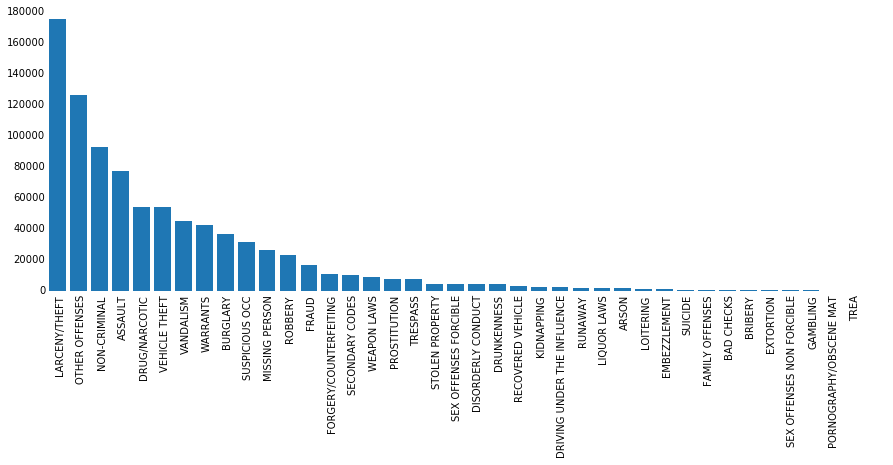

In [237]:
#print cat_counts
fig, ax = plt.subplots(figsize=(15,5))
width = .80
ax.bar(np.arange(39),
       cat_counts.values,
       width,
       color="#1f77b4",
       edgecolor='none')

ax.set_xticks(np.arange(39) + .5)
ax.set_xticklabels(np.asarray(cat_counts.axes).flatten(), rotation='vertical')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tick_params(
            axis='both', 
            which='both',
            bottom='off',
            left='off',
            top='off',
            right='off')
plt.show()


In [166]:
for field, values in trainDF.iteritems():
    print "Total number of Unique values for " + field + ": " + str(len(values.value_counts()))

Total number of Unique values for Dates: 389229
Total number of Unique values for Category: 39
Total number of Unique values for Descript: 879
Total number of Unique values for DayOfWeek: 7
Total number of Unique values for PdDistrict: 10
Total number of Unique values for Resolution: 17
Total number of Unique values for Address: 23191
Total number of Unique values for X: 34242
Total number of Unique values for Y: 34242
Total number of Unique values for Time: 24
Total number of Unique values for Day: 31
Total number of Unique values for Month: 12
Total number of Unique values for Year: 13
Total number of Unique values for IsIntersection: 2
Total number of Unique values for Awake: 2
Total number of Unique values for Summer: 2
Total number of Unique values for Fall: 2
Total number of Unique values for Winter: 2
Total number of Unique values for Spring: 2
Total number of Unique values for Street1: 2031
Total number of Unique values for Street2: 2057


# Features

In [45]:
def parse_time(x):
    DD=datetime.strptime(x,"%Y-%m-%d %H:%M:%S")
    time=DD.hour#*60+DD.minute
    day=DD.day
    month=DD.month
    year=DD.year
    return time,day,month,year

def get_season(x):
    summer=0
    fall=0
    winter=0
    spring=0
    if (x in [5, 6, 7]):
        summer=1
    if (x in [8, 9, 10]):
        fall=1
    if (x in [11, 0, 1]):
        winter=1
    if (x in [2, 3, 4]):
        spring=1
    return summer, fall, winter, spring

def get_street(x):
    if  "/" in x: 
        return re.findall(r'([A-Z0-9 ]+)\s/\s?([A-Z0-9 ]*)', x)[0]
    else: 
        street = re.findall(r'\d+.*?\s+Block of ([A-Z0-9 ]+)', x)[0]
        return street,street

In [269]:
#Jackson Code

groupKey = ["Awake","PdDistrict","Address"]

def engineer_data(df):
    
    df2 = df.copy()
    df2["Time"], df2["Day"], df2["Month"], df2["Year"]=zip(*df2["Dates"].apply(parse_time))    
    df2["IsIntersection"]=df2["Address"].apply(lambda x: 1 if "/" in x else 0)
    df2["Awake"]=df2["Time"].apply(lambda x: 1 if (x==0 or (x>=8 and x<=23)) else 0)
    df2["Summer"], df2["Fall"], df2["Winter"], df2["Spring"]=zip(*df2["Month"].apply(get_season))
    df2["Street1"],df2["Street2"] = zip(*df2["Address"].apply(get_street))
    return df2

In [129]:
trainDF = engineer_data(trainDF)

In [334]:
def createLogOdds(togroup,X,y=None,p=False):
        categories=sorted(y.unique())
        X2 = X.assign(Category=y.astype('object'))
        C_counts=X2.groupby(["Category"]).size()
        def recurseLogOdds(key):
            if len(key) < 1: 
                return np.log(C_counts/len(X2))-np.log(1.0-C_counts/float(len(X2)))
            parent_logodds= recurseLogOdds(key[:-1])
            G_C_counts=X2.groupby(key +["Category"]).size()
            G_counts=X2.groupby( key).size()
            groups=G_counts.keys()        
            logodds={}
            MIN_CAT_COUNTS=1
            for addr in groups:
                if len(key) == 2:
                    default =parent_logodds[addr[0]]
                elif len(key) > 2:
                    default =parent_logodds[addr[:-1]]
                else: default = parent_logodds
                logodds[addr]=deepcopy(default)
                for cat in G_C_counts[addr].keys():
                    if (G_C_counts[addr][cat]>MIN_CAT_COUNTS) and G_C_counts[addr][cat]<G_counts[addr]:
                        PA=G_C_counts[addr][cat]/float(G_counts[addr])
                        logodds[addr][categories.index(cat)]=np.log(PA)-np.log(1.0-PA)

            return logodds
        logodds = recurseLogOdds(togroup)
        return pd.DataFrame(logodds.values(), index=pd.MultiIndex.from_tuples(logodds.keys()))



C_counts=trainDF.groupby(["Category"]).size()

default_logodds=np.log(C_counts/len(trainDF))-np.log(1.0-C_counts/float(len(trainDF)))



import sys,random
def getLogOdds(key,logodds):
    if( random.random() > .999):
            sys.stdout.write('.')
    while (len(key) > 0):
        if key in logodds.index:
            return np.mean(np.atleast_2d(logodds.loc[key]),axis=0)
        else: key = key[:-1]
    return pd.Series(default_logodds.values)


In [ ]:
labels = trainDF["Category"].astype('category')

In [271]:
logodds = createLogOdds(groupKey,trainDF,trainDF.loc[:,"Category"],True)

In [ ]:
def parse_data(df,logodds,logoddsPA,togroup=["Address"]):
    
    feature_list=df.columns.tolist()
    
    if "Descript" in feature_list:
        feature_list.remove("Descript")
    if "Resolution" in feature_list:
        feature_list.remove("Resolution")
    if "Category" in feature_list:
        feature_list.remove("Category")
    if "Id" in feature_list:
        feature_list.remove("Id")
        
    cleanData=df[feature_list]
    cleanData.index=range(len(df))
    
    print "Creating address features"
    
    address_features=cleanData[togroup].apply(lambda x: pd.Series(getLogOdds(tuple(x),logodds)),axis=1)
    print(address_features.shape)
    address_features.columns=["logodds"+str(x) for x in range(len(address_features.columns))]
    
    print "Parsing dates"
    cleanData["Time"], cleanData["Day"], cleanData["Month"], cleanData["Year"]=zip(*cleanData["Dates"].apply(parse_time))
#     dummy_ranks_DAY = pd.get_dummies(cleanData['DayOfWeek'], prefix='DAY')
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#     cleanData["DayOfWeek"]=cleanData["DayOfWeek"].apply(lambda x: days.index(x)/float(len(days)))

    print "Creating one-hot variables"
    dummy_ranks_PD = pd.get_dummies(cleanData['PdDistrict'], prefix='PD')
    dummy_ranks_DAY = pd.get_dummies(cleanData["DayOfWeek"], prefix='DAY')
    
    cleanData["IsIntersection"]=cleanData["Address"].apply(lambda x: 1 if "/" in x else 0)
    cleanData["logoddsPA"]=cleanData["Address"].apply(lambda x: logoddsPA[x])
    
    print "droping processed columns"
    cleanData=cleanData.drop("PdDistrict",axis=1)
    cleanData=cleanData.drop("DayOfWeek",axis=1)
    cleanData=cleanData.drop("Address",axis=1)
    cleanData=cleanData.drop("Dates",axis=1)
    cleanData=cleanData.drop("Street1",axis=1)
    cleanData=cleanData.drop("Street2",axis=1)

    feature_list=cleanData.columns.tolist()
    
    print "joining one-hot features"
    features = cleanData[feature_list].join(dummy_ranks_PD.ix[:,:]).join(dummy_ranks_DAY.ix[:,:]).join(address_features.ix[:,:])
    
    print "creating new features"
    features["IsDup"]=pd.Series(features.duplicated()|features.duplicated(take_last=True)).apply(int)
    features["Awake"]=features["Time"].apply(lambda x: 1 if (x==0 or (x>=8 and x<=23)) else 0)
    features["Summer"], features["Fall"], features["Winter"], features["Spring"]=zip(*features["Month"].apply(get_season))
    if "Category" in df.columns:
        labels = df["Category"].astype('category')
#         label_names=labels.unique()
#         labels=labels.cat.rename_categories(range(len(label_names)))
    else:
        labels=None
    return features,labels

This part is slower than it needs to be.

In [ ]:
addresses=sorted(trainDF["Address"].unique())
categories=sorted(trainDF["Category"].unique())

C_counts=trainDF.groupby(["Category"]).size()
A_C_counts=trainDF.groupby(["Address","Category"]).size()

A_counts=trainDF.groupby(["Address"]).size()

#logodds={}
logoddsPA={}

MIN_CAT_COUNTS=2

default_logodds=np.log(C_counts/len(trainDF))-np.log(1.0-C_counts/float(len(trainDF)))

for addr in addresses:
    PA=A_counts[addr]/float(len(trainDF))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)

In [ ]:
features, labels=parse_data(trainDF,logodds.sortlevel(),logoddsPA,groupKey)

In [335]:
print features.columns.tolist()
print len(features.columns)

['X', 'Y', 'Time', 'Day', 'Month', 'Year', 'IsIntersection', 'Awake', 'Summer', 'Fall', 'Winter', 'Spring', 'logoddsPA', 'PD_BAYVIEW', 'PD_CENTRAL', 'PD_INGLESIDE', 'PD_MISSION', 'PD_NORTHERN', 'PD_PARK', 'PD_RICHMOND', 'PD_SOUTHERN', 'PD_TARAVAL', 'PD_TENDERLOIN', 'DAY_Friday', 'DAY_Monday', 'DAY_Saturday', 'DAY_Sunday', 'DAY_Thursday', 'DAY_Tuesday', 'DAY_Wednesday', 'logodds0', 'logodds1', 'logodds2', 'logodds3', 'logodds4', 'logodds5', 'logodds6', 'logodds7', 'logodds8', 'logodds9', 'logodds10', 'logodds11', 'logodds12', 'logodds13', 'logodds14', 'logodds15', 'logodds16', 'logodds17', 'logodds18', 'logodds19', 'logodds20', 'logodds21', 'logodds22', 'logodds23', 'logodds24', 'logodds25', 'logodds26', 'logodds27', 'logodds28', 'logodds29', 'logodds30', 'logodds31', 'logodds32', 'logodds33', 'logodds34', 'logodds35', 'logodds36', 'logodds37', 'logodds38', 'IsDup']
70


### Normalize the features
We scale the data to ensure equal importance for each feature

In [ ]:
collist=features.columns.tolist()
scaler = preprocessing.StandardScaler()
scaler.fit(features)
features[collist]=scaler.transform(features)

[ 0.05473658  0.03641064  0.03582185  0.03012748  0.02998278  0.02688983
  0.02613109  0.02410742  0.02301878  0.02148769  0.02092218  0.01899653
  0.01884296  0.01836198  0.01782279  0.01770954  0.01725059  0.01712257
  0.01688062  0.01670656  0.01636302  0.01623761  0.01582838  0.01573838
  0.01559988  0.01542468  0.01526985  0.0150908   0.01492956  0.01462768
  0.01414341  0.01399689  0.01393581  0.01375206  0.01355437  0.01337974
  0.01322612  0.01302616  0.01282112  0.01270593  0.01238375  0.01228543
  0.01202855  0.011711    0.01161486  0.01121134  0.01093099  0.01088867
  0.01076491  0.01032512  0.01017502  0.00948734  0.00902173  0.00892866
  0.00853474  0.00851008  0.00762871  0.00746398  0.00597961  0.00572424
  0.00535323  0.00515581  0.00488084  0.00425379]


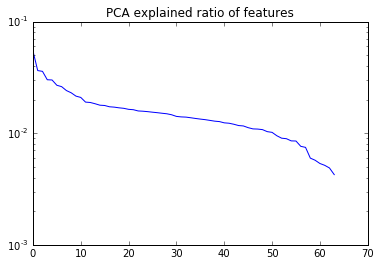

In [239]:

new_PCA=PCA(n_components=64)
new_PCA.fit(features)
plt.plot(new_PCA.explained_variance_ratio_)
plt.yscale('log')
plt.title("PCA explained ratio of features")
print new_PCA.explained_variance_ratio_


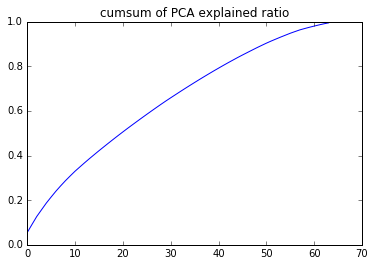

In [240]:

plt.plot(new_PCA.explained_variance_ratio_.cumsum())
plt.title("cumsum of PCA explained ratio")


PCA is interesting, here to play with it more

In [ ]:
# features=new_PCA.transform(features)
# features=pd.DataFrame(features)

### Common pitfall:
An important point to make about the preprocessing is that any preprocessing statistics (e.g. the data mean) must only be computed on the training data, and then applied to the validation / test data. E.g. computing the mean and subtracting it from every image across the entire dataset and then splitting the data into train/val/test splits would be a mistake. Instead, the mean must be computed only over the training data and then subtracted equally from all splits (train/val/test). http://cs231n.github.io/neural-networks-2/#datapre

We fell for this. Thus we keep in mind that our logloss results may be different from the actual kaggle ones.



In [ ]:
sss = StratifiedShuffleSplit(labels, train_size=0.5)
for train_index, test_index in sss:
    features_train,features_test=features.iloc[train_index],features.iloc[test_index]
    labels_train,labels_test=labels[train_index],labels[test_index]
features_test.index=range(len(features_test))
features_train.index=range(len(features_train))
labels_train.index=range(len(labels_train))
labels_test.index=range(len(labels_test))
features.index=range(len(features))
labels.index=range(len(labels))

In [ ]:
def build_and_fit_model(X_train,y_train,X_test=None,y_test=None,hn=128,dp=0.5,layers=1,epochs=1,batches=64,verbose=0):
    input_dim=X_train.shape[1]
    output_dim=len(labels_train.unique())
    Y_train=y_train.cat.rename_categories(range(len(y_train.unique())))

    model = Sequential()
    model.add(Dense(input_dim=input_dim, output_dim=hn, init='glorot_uniform'))
    model.add(PReLU(input_shape=(hn,)))
    model.add(Dropout(dp))

    model.add(Dense(input_dim=hn, output_dim=hn,init='glorot_uniform'))
    model.add(PReLU(input_shape=(hn,)))
    model.add(BatchNormalization())
    model.add(GaussianNoise(.05))
    model.add(Dropout(dp))

    model.add(Dense(input_dim=hn, output_dim=output_dim,init='glorot_uniform'))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    
    if X_test is not None:
        Y_test=y_test.cat.rename_categories(range(len(y_test.unique())))
        fitting=model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=batches,verbose=verbose,validation_data=(X_test,Y_test))
        test_score = log_loss(y_test, model.predict_proba(X_test,verbose=0))
    else:
        model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=batches,verbose=verbose)
        fitting=0
        test_score = 0
    return test_score, fitting, model

In [131]:
N_EPOCHS=50
N_HN=512
N_LAYERS=1
DP=0.5

In [255]:
score, fitting, model = build_and_fit_model(features_train.as_matrix(),labels_train,X_test=features_test.as_matrix(),y_test=labels_test,hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)

In [133]:
print "all", log_loss(labels, model.predict_proba(features.as_matrix(),verbose=0))
print "train", log_loss(labels_train, model.predict_proba(features_train.as_matrix(),verbose=0))
print "test", log_loss(labels_test, model.predict_proba(features_test.as_matrix(),verbose=0))

all 1.89503502025
train 1.84408646157
test 1.94597773205


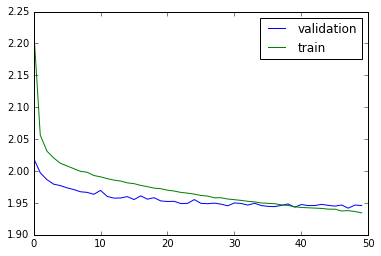

In [134]:
plt.plot(fitting.history['val_loss'],label="validation")
plt.plot(fitting.history['loss'],label="train")
# plt.xscale('log')
plt.legend()

Now train the final model

In [249]:
score, fitting, model = build_and_fit_model(features.as_matrix(),labels,hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)

Epoch 1/50
363s - loss: 2.1431
Epoch 2/50
364s - loss: 2.0316
Epoch 3/50
363s - loss: 2.0178
Epoch 4/50
364s - loss: 2.0107
Epoch 5/50
362s - loss: 2.0057
Epoch 6/50
365s - loss: 2.0006
Epoch 7/50
361s - loss: 1.9973
Epoch 8/50
362s - loss: 1.9950
Epoch 9/50
362s - loss: 1.9917
Epoch 10/50
362s - loss: 1.9889
Epoch 11/50
362s - loss: 1.9870
Epoch 12/50
361s - loss: 1.9847
Epoch 13/50
361s - loss: 1.9824
Epoch 14/50
361s - loss: 1.9806
Epoch 15/50
361s - loss: 1.9783
Epoch 16/50
357s - loss: 1.9766
Epoch 17/50
356s - loss: 1.9749
Epoch 18/50
355s - loss: 1.9730
Epoch 19/50
355s - loss: 1.9717
Epoch 20/50
355s - loss: 1.9711
Epoch 21/50
354s - loss: 1.9699
Epoch 22/50
354s - loss: 1.9678
Epoch 23/50
354s - loss: 1.9665
Epoch 24/50
355s - loss: 1.9657
Epoch 25/50
356s - loss: 1.9647
Epoch 26/50
358s - loss: 1.9635
Epoch 27/50
358s - loss: 1.9636
Epoch 28/50
359s - loss: 1.9611
Epoch 29/50
358s - loss: 1.9611
Epoch 30/50
358s - loss: 1.9595
Epoch 31/50
357s - loss: 1.9585
Epoch 32/50
356s 

In [250]:
score, fitting, model = build_and_fit_model(features.as_matrix(),labels,hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)

In [286]:
print "all", log_loss(labels, model.predict_proba(features.as_matrix(),verbose=0))
print "train", log_loss(labels_train, model.predict_proba(features_train.as_matrix(),verbose=0))
log_loss_test = log_loss(labels_test, model.predict_proba(features_test.as_matrix(),verbose=0))
print "test", log_loss_test

all 1.87664961524
train 1.87690345894
test 1.87639069928


In [310]:
y_pred = model.predict_classes(features_lim.as_matrix(),verbose=0)

In [ ]:
labels_list = np.asarray(labels.cat.rename_categories(range(len(labels.unique()))))

In [322]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(39)
    plt.xticks(tick_marks,labels.cat.categories, rotation=90)
    plt.yticks(tick_marks,labels.cat.categories)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [323]:
# Compute confusion matrix
cm = confusion_matrix(labels_list, y_pred)

Confusion matrix
[[   96   174     0 ...,    76    36     5]
 [   13 29873     2 ...,  1636  1549   248]
 [    0    36     3 ...,     7    14     0]
 ..., 
 [   15  1534     0 ..., 27408   365    41]
 [    5  3084     0 ...,   992 10145   165]
 [    5  1127     0 ...,   286   308  1777]]


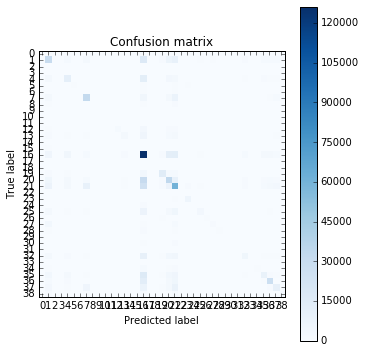

In [327]:
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure(figsize=(5,5))
plot_confusion_matrix(cm)
plt.show()

    

In [138]:
store = pd.HDFStore("/tmp/my_logodds2.hdf5",complib='blosc')
store['my_logodds'] = logodds
store.close()
    
#logodds = pd.read_hdf('/tmp/mydf.hdf5', 'mydf')

In [90]:
store = pd.HDFStore("/tmp/my_logoddsPA.hdf5",complib='blosc')
store['my_logoddsPA'] = logoddsPA
store.close()

In [139]:
features_train.to_csv(os.path.join(data_path,'features_train2.csv'),index_label="Id",na_rep="0")
labels_train.to_csv(os.path.join(data_path,'labels_train2.csv'),header=False, index=False)

In [140]:
features_test.to_csv(os.path.join(data_path,'features_dev2.csv'),index_label="Id",na_rep="0")
labels_test.to_csv(os.path.join(data_path,'labels_dev2.csv'),header=False, index=False)

In [141]:
features.to_csv(os.path.join(data_path,'features_all2.csv'),index_label="Id",na_rep="0")
labels.to_csv(os.path.join(data_path,'labels_all2.csv'),header=False, index=False)

In [142]:
from keras.models import model_from_json
json_string = model.to_json()
open('my_model_architecture_2.json', 'w').write(json_string)
model.save_weights('my_model_weights.h5')
model2 = model_from_json(open('my_model_architecture_2.json').read())
model2.load_weights('my_model_weights.h5')
print model2

[WARNING] my_model_weights.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True in save_weights!


In [256]:
testDF=pd.read_csv(os.path.join(data_path,"test.csv"))
testDF[["X","Y"]]=xy_scaler.transform(testDF[["X","Y"]])
#set outliers to 0
testDF["X"]=testDF["X"].apply(lambda x: 0 if abs(x)>5 else x)
testDF["Y"]=testDF["Y"].apply(lambda y: 0 if abs(y)>5 else y)

In [257]:
testDF = engineer_data(testDF)

In [267]:
new_addresses=sorted(testDF["Address"].unique())
new_A_counts=testDF.groupby("Address").size()
only_new=set(new_addresses+addresses)-set(addresses)
only_old=set(new_addresses+addresses)-set(new_addresses)
in_both=set(new_addresses).intersection(addresses)
for addr in only_new:
    PA=new_A_counts[addr]/float(len(testDF)+len(trainDF))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)
    #logodds[addr]=deepcopy(default_logodds)
    #logodds[addr].index=range(len(categories))
for addr in in_both:
    PA=(A_counts[addr]+new_A_counts[addr])/float(len(testDF)+len(trainDF))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)
print PA    

1.98610408093e-05


In [272]:
features_sub, _=parse_data(testDF,logodds.sortlevel(),logoddsPA,groupKey)

Creating address features
(884262, 39)
Parsing dates


/Users/koza/ipykernel/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Creating one-hot variables


/Users/koza/ipykernel/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


droping processed columns
joining one-hot features
creating new features


/Users/koza/ipykernel/ipykernel/__main__.py:50: FutureWarning: the take_last=True keyword is deprecated, use keep='last' instead


In [336]:
collist=features_sub.columns.tolist()


In [274]:
features_sub[collist]=scaler.transform(features_sub[collist])

In [279]:
features_sub.head()

,X,Y,Time,Day,Month,IsIntersection,Awake,Summer,Fall,Winter,...,logodds30,logodds31,logodds32,logodds33,logodds34,logodds35,logodds36,logodds37,logodds38,IsDup
0,0.005803,0.164938,1.463812,-0.634239,-0.418903,-0.649964,0.390475,1.72683,-0.579573,-0.447534,...,-0.623217,-0.756332,1.210873,4.158325,-0.416158,0.514910,-0.129970,0.539681,0.882597,-0.795028
1,0.005803,0.164938,1.463812,-0.634239,-0.418903,1.538547,0.390475,1.72683,-0.579573,-0.447534,...,-0.623217,-0.756332,-0.607420,4.158325,-0.416158,-0.098032,0.074574,1.059291,0.087551,-0.795028
2,0.005803,0.164938,1.463812,-0.634239,-0.418903,-0.649964,0.390475,1.72683,-0.579573,-0.447534,...,0.136954,0.112455,-0.420603,-0.978277,-0.643087,-0.351299,1.790152,-0.567865,-0.582997,-0.795028
3,0.005803,0.164938,1.463812,-0.634239,-0.418903,-0.649964,0.390475,1.72683,-0.579573,-0.447534,...,-0.450961,0.499366,0.632753,-0.978277,-0.476850,0.670186,-1.775603,-0.115227,1.069353,1.257817
4,0.005803,0.164938,1.463812,-0.634239,-0.418903,-0.649964,0.390475,1.72683,-0.579573,-0.447534,...,-0.450961,0.499366,0.632753,-0.978277,-0.476850,0.670186,-1.775603,-0.115227,1.069353,1.257817


In [280]:
predDF=pd.DataFrame(model.predict_proba(features_sub.as_matrix(),verbose=0),columns=sorted(labels.unique()))

In [ ]:
predDF.head()

In [337]:
import time


In [283]:
predDF.to_csv(os.path.join(submissions_path, "NN_at"+str(log_loss_test)+"_"+str(time.time())+".csv"),index_label="Id",na_rep="0")

In [ ]:
features_sub.head()

In [120]:
classifier = LogisticRegression()
lrmodel = classifier.fit(features.as_matrix(),labels)
print lrmodel.score(features_test.as_matrix(),labels_test)

0.400099774937



LR score: 0.400099774937
Previous LR score: 0.339571924517

In [ ]:
classifier = LogisticRegression()
lrmodel = classifier.fit(features_lim.as_matrix(),labels)
lr_score = lrmodel.score(features_test.as_matrix(),labels_test)
print "LR score: ", lr_score

In [ ]:
lr_loss = log_loss(labels_test, lrmodel.predict_proba(features_test.as_matrix()))
print "LR loss test", lr_loss
predDF_LR=pd.DataFrame(lrmodel.predict_proba(features_sub.as_matrix()),columns=sorted(labels.unique()))

In [122]:
predDF_LR.to_csv(os.path.join(submissions_path, "LR_logodds_"+str(lr_loss)+"_"+str(time.time())+".csv"),index_label="Id",na_rep="0")

LR loss test 2.03290841761


LR loss test 2.03290841761
Previous LR loss test 2.16467326317

In [343]:
features_sub.shape

(884262, 69)

In [ ]:
classifier = RandomForestClassifier()
rf_model = classifier.fit(features_lim.as_matrix(),labels)
rf_score = rf_model.score(features_test.as_matrix(),labels_test)
print "RF Score ",rf_score

RF Score  0.840241646696

In [344]:
rf_loss = log_loss(labels_test, rf_model.predict_proba(features_test.as_matrix()))
print "RF loss test", rf_loss
predDF_RF = pd.DataFrame(rf_model.predict_proba(features_sub.as_matrix()),columns=sorted(labels.unique()))

RF loss test 0.503240105522


In [346]:
predDF_RF.to_csv(os.path.join(submissions_path, "RF_logodds_"+str(rf_loss)+"_"+str(time.time())+".csv"),index_label="Id",na_rep="0")